In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Plotting methylation fractions across genomic regions

This notebook illustrates how [```modality```](https://modality-docs.biomodal.com/index.html) can be used to quickly and easily generate methylation trace plots - summarising methylation fractions across a genomic region of interest. This functionality offers a very rapid way to explore key genomic regions - as defined by your own research questions - and generate extensible plots. The core method provides a wrapper to [```seaborn.relplot```](https://seaborn.pydata.org/generated/seaborn.relplot.html) allowing full customisation.

## Load the data

For the purposes of this demo we can use a duet evoC dataset of mouse ES-E14 cells. The data are publicly available and can be loaded using the [```load_biomodal_dataset()```](https://modality-docs.biomodal.com/modality.html#modality.datasets.load_biomodal_dataset) function. This will pull the dataset and load it in to our session as a [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset) object.

In [2]:
from modality.datasets import load_biomodal_dataset

In [3]:
ds = load_biomodal_dataset("esE14")
ds

ContigDataset(data_vars=Data variables:
    num_c                           (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_hmc                         (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_mc                          (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_modc                        (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_other                       (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_total                       (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    num_total_c                     (pos, sample_id) uint16 dask.array<chunksize=(100000, 4), meta=np.ndarray>
    Input DNA Quantity (ng/sample)  (sample_id) int64 80 80 80 80
    Protocol Version                (sample_id) object '6-Letter v0.1.8' ... ...
    tech_replicate_number           (sample_id) int64 1 2 3 4, coords=Coordinates:
    contig        (pos) <U5 dask.array<chunksize=(100000,), meta=np.ndarray>
    group         (sample_id) <U22 'CEG1485-EL01-D1115-001' ... 'CEG1485-EL01...
    ref_position  (pos) int64 dask.array<chunksize=(100000,), meta=np.ndarray>
  * sample_id     (sample_id) <U22 'CEG1485-EL01-D1115-001' ... 'CEG1485-EL01...
    strand        (pos) <U2 dask.array<chunksize=(100000,), meta=np.ndarray>, attrs={'context': 'CG', 'context_sampling': 1.0, 'contigs': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT'], 'coordinate_basis': 0, 'fasta_path': 'GRCm38-ss-ctrls-v23.fa.gz', 'input_path': ['CEG1485-EL01-D1115-001.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-002.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-003.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz', 'CEG1485-EL01-D1115-004.genome.GRCm38.dedup.duet-modC.CG_quant.tsv.gz'], 'quant_type': 'quant6L', 'ref_name': 'GRCm38', 'sample_ids': ['CEG1485-EL01-D1115-001', 'CEG1485-EL01-D1115-002', 'CEG1485-EL01-D1115-003', 'CEG1485-EL01-D1115-004'], 'slice_1': slice(0, 1737408, 1), 'slice_10': slice(13946402, 15311424, 1), 'slice_11': slice(15311424, 16849294, 1), 'slice_12': slice(16849294, 18005730, 1), 'slice_13': slice(18005730, 19196682, 1), 'slice_14': slice(19196682, 20320810, 1), 'slice_15': slice(20320810, 21410730, 1), 'slice_16': slice(21410730, 22319618, 1), 'slice_17': slice(22319618, 23386164, 1), 'slice_18': slice(23386164, 24278174, 1), 'slice_19': slice(24278174, 25010342, 1), 'slice_2': slice(1737408, 3662080, 1), 'slice_3': slice(3662080, 5043804, 1), 'slice_4': slice(5043804, 6647958, 1), 'slice_5': slice(6647958, 8321048, 1), 'slice_6': slice(8321048, 9714434, 1), 'slice_7': slice(9714434, 11153720, 1), 'slice_8': slice(11153720, 12605040, 1), 'slice_9': slice(12605040, 13946402, 1), 'slice_MT': slice(26073706, 26074280, 1), 'slice_X': slice(25010342, 25760674, 1), 'slice_Y': slice(25760674, 26073706, 1), 'description': 'An evoC dataset of mouse ES-E14 cells, data contains 4 technical replicates.\nThese data aligned to the mm38 genome.'})

## Extract specific genomic regions

We can use the slice functionality of the [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset) to extract a specific genomic region prior to plotting the methylation trace. Below we specify three seperate data slices to show some methylation trace plots.

In [4]:
# Specify some genomic regions for downstream plotting - specified as chr:start-end
sliced_data= {
    "slice_1": ds["10:44391523-44392442"],
    "tet1_slice": ds["10:62804569-62908995"],
    "tet3_slice": ds["6:83362372-83459083"],
}

## Generate methylation trace plots

Using the slices of data defined above we can easily generate methylation trace plots to show how different samples in the dataset vary in their methylation fractions across specified genomic regions. To do so we make use of the ```plot_methylation_trace()``` method from [```ContigDataset```](https://modality-docs.biomodal.com/modality.html#module-modality.contig_dataset). This method computes methylation fractions from the specified ```num_*``` variables (specified with the numerators argument) against a ```num_total*``` variable and will return a [```seaborn.relplot```](https://seaborn.pydata.org/generated/seaborn.relplot.html) plot.

***Please note: this method is meant for plotting small regions covering up to a maximum of 200,000 CpGs.***

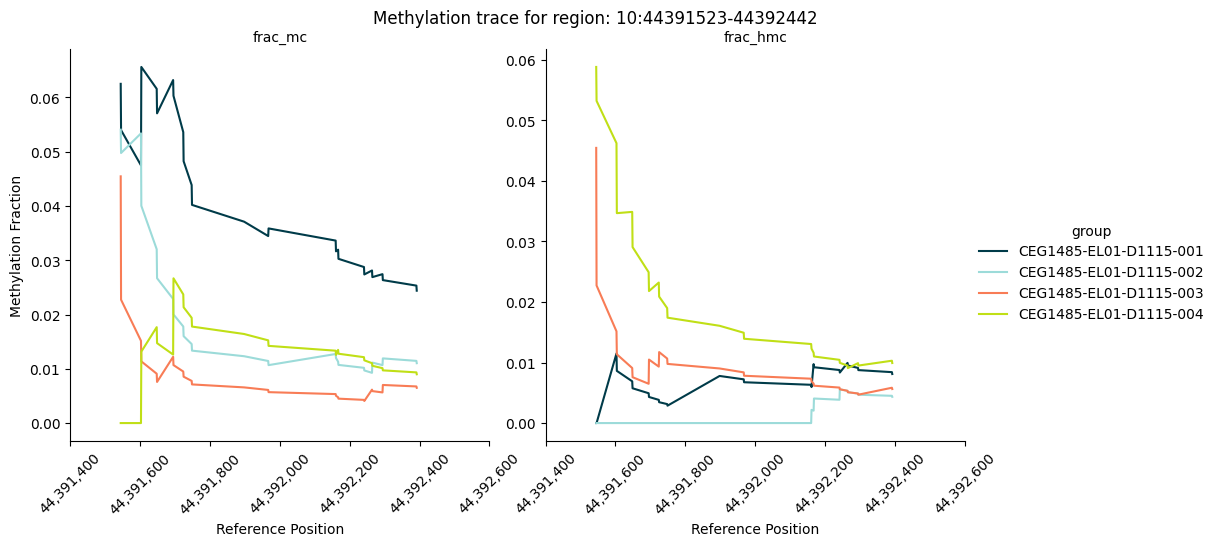

In [5]:
sliced_data['slice_1'].plot_methylation_trace(
    numerators=["num_mc", "num_hmc"],
    denominator="num_total_c",
    min_coverage=10,
    title="Methylation trace for region: 10:44391523-44392442",
)

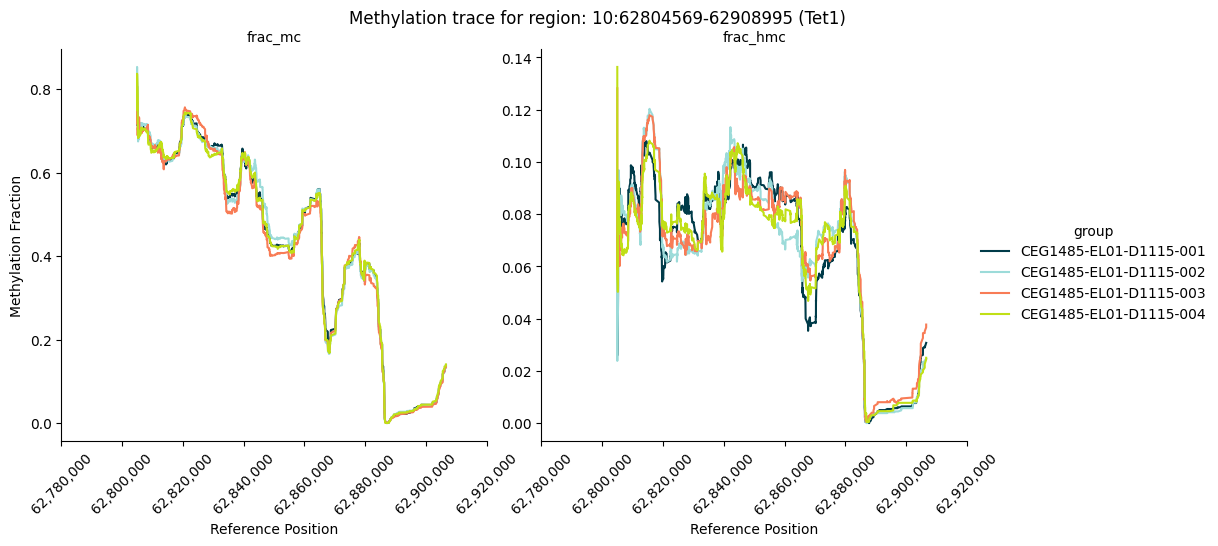

In [6]:
sliced_data['tet1_slice'].plot_methylation_trace(
    numerators=["num_mc", "num_hmc"],
    denominator="num_total_c",
    min_coverage=10,
    title="Methylation trace for region: 10:62804569-62908995 (Tet1)",
)

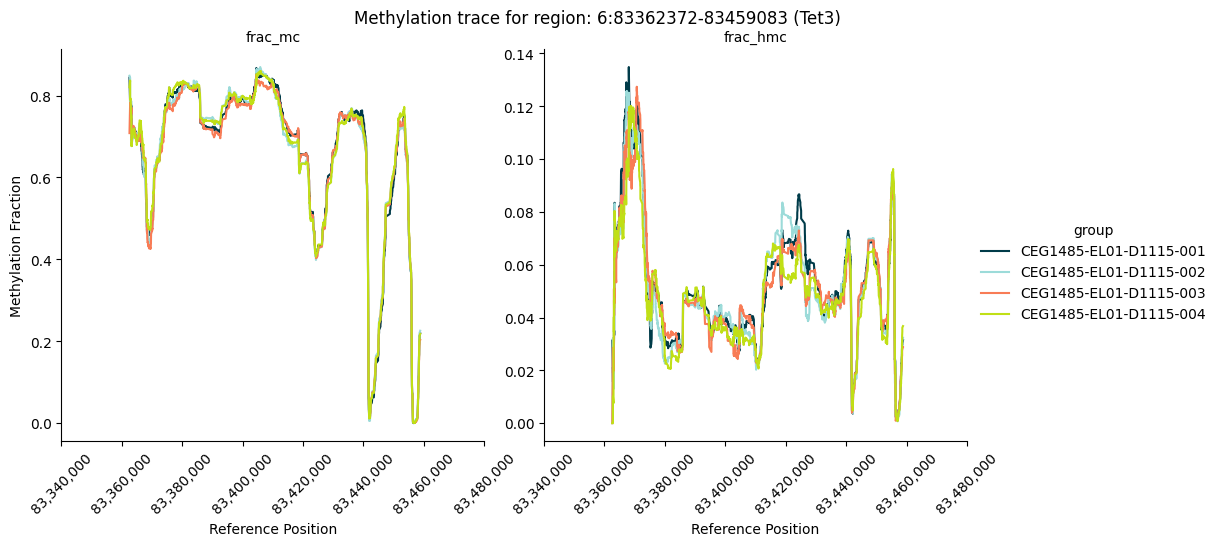

In [7]:
sliced_data['tet3_slice'].plot_methylation_trace(
    numerators=["num_mc", "num_hmc"],
    denominator="num_total_c",
    min_coverage=10,
    title="Methylation trace for region: 6:83362372-83459083 (Tet3)",
)